In [10]:
from id01sware.id01lib.xrd.qconversion import get_qspace_vals
from id01sware.id01lib.xrd.detectors import MaxiPix
from id01sware.id01lib.xrd.geometries import ID01psic
import xrayutilities as xu
from lib.calc import *

Initalise some variables

In [4]:
angles = geometry.sample_rot.copy()
angles.update(geometry.detector_rot) 

In [9]:
angles

OrderedDict([('mu', 'z-'),
             ('eta', 'y-'),
             ('phi', 'z-'),
             ('rhx', 'y+'),
             ('rhy', 'x-'),
             ('rhz', 'z+'),
             ('nu', 'z-'),
             ('delta', 'y-')])

In [11]:
cen_pix = [238.654,336.100]
distance = 0.411
fname = '../data/hc3211.h5'
detector = MaxiPix()
geometry = ID01psic()
energy = 8000
ipdir = [1,0,0]
ndir = [0,0,1]

In [12]:
geometry.usemotors

{'delta', 'eta', 'nu', 'phi'}

In [13]:
scans = [42,43,44,45]

final_array = np.load('../stitched_data/42_45.npy')

In [14]:
%whos ndarray list

Variable      Type       Data/Info
----------------------------------
cen_pix       list       n=2
final_array   ndarray    704x516x516: 187444224 elems, type `float32`, 749776896 bytes (715.04296875 Mb)
ipdir         list       n=3
ndir          list       n=3
scans         list       n=4


The following initalises the area detector object and the angles

In [12]:
motors = dict()
with h5py.File(fname,'r') as h5f:
    pos = h5f['E16014/'+str(scans[0])+'.1/instrument/positioners']
    for motor in pos:
        motors[motor] = pos[motor].value
# add mpx offset to central pixel (as meas from det_calib)
cen_pix[0] += motors["mpxz"]/1000. / detector.pixsize[0]
cen_pix[1] -= motors["mpxy"]/1000. / detector.pixsize[1]
# initialise the experiment class feeding the ID01psic geometry to it
hxrd = xu.HXRD([1,0,0], [0,0,1], en=8000, qconv=geometry.getQconversion())
# select the whole detector as the roi
roi = [0, detector.pixnum[0], 0, detector.pixnum[1]]
# initalise the area detector
hxrd.Ang2Q.init_area(detector.directions[0],
                     detector.directions[1],
                     cch1=cen_pix[0],
                     cch2=cen_pix[1],
                     Nch1=detector.pixnum[0],
                     Nch2=detector.pixnum[1],
                     pwidth1=detector.pixsize[0],
                     pwidth2=detector.pixsize[1],
                     distance=distance,
                     roi=roi)
# get the angles of the ID01psic geometry
angles = geometry.sample_rot.copy()
angles.update(geometry.detector_rot) 

OSError: Unable to open file (unable to open file: name = '../data/hc3211.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [16]:
hxrd.Ang2Q.area?

In [8]:
with h5py.File(fname,'r') as h5f:
    eta_vals = []
    for scan in scans:
        eta_vals.append(h5f['E16014/'+str(scan)+'.1/instrument/positioners/eta'].value)
    eta = np.concatenate((eta_vals))

In [9]:
maxlen = 1
motors['eta'] = eta.astype('float64')
for angle in angles:
    if angle in geometry.usemotors:
        # fetch experimental angle value
        dset = motors[angle if angle is not "delta" else "del"]
        if len(dset.shape): # if it's 0 motor is still, if it's 1 motor is changing during scan
            maxlen = max(maxlen, dset.shape[0])
        position = dset
    else:
        position = 0.
    angles[angle] = position - geometry.offsets[angle]
# output: ordered dict with offset corrected angles of interest used during a scan.

In [10]:
angles.keys()

odict_keys(['mu', 'eta', 'phi', 'rhy', 'rhx', 'nu', 'delta'])

In [11]:
# if the angle is kept constant during a scan, it is a scalar. If that's the case,
# make it the same shape as the angle(s) which is being varied during a scan
for angle in angles:
    if np.isscalar(angles[angle]): 
        angles[angle] = np.ones(maxlen, dtype=float) * angles[angle]

In [12]:
for angle in angles:
    print(angle, angles[angle].shape)

mu (704,)
eta (704,)
phi (704,)
rhy (704,)
rhx (704,)
nu (704,)
delta (704,)


In [13]:
# convert to q space, using central pixel and other stuff defined by the init_area routine.
qx, qy, qz = hxrd.Ang2Q.area(*angles.values())
%matplotlib inline

Check that it's ok:

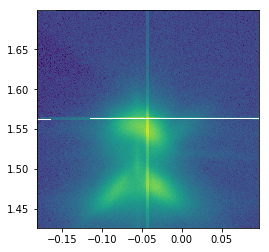

In [32]:
plt.pcolormesh(qy[0,:,:],qz[0,:,:],np.log(final_array[200,:,:]))
plt.axis('image');
plt.show()

Problem is data is not on reg grid now:

In [15]:
data = final_array
a,b,c = qx[1,0,0]-qx[0,0,0], qy[0,1,0]-qy[0,0,0], qz[0,0,1]-qz[0,0,0]
print(a)
print(b)
print(c)

0.00025682361368
-7.71786079046e-07
6.27079669924e-06


The yz plane looks ok:

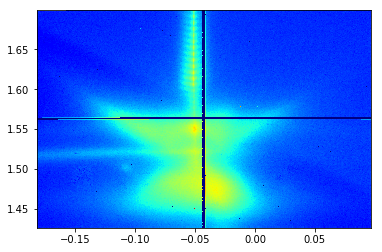

In [16]:
plt.pcolormesh(qy[0,:,:],qz[0,:,:],np.log(final_array[400:,:,:].sum(axis=0)),cmap='jet');plt.show()

But the y and z indexes in q's look inverted:

In [23]:
qy.shape

(704, 516, 516)

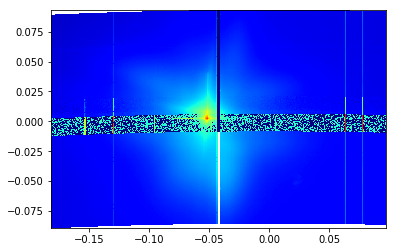

In [27]:
plt.pcolormesh(qy[:,0,:],qx[:,0,:],np.log(final_array[:,:350,:].sum(axis=1)),cmap='jet');plt.show()

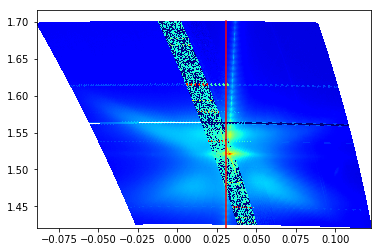

In [25]:
plt.pcolormesh(qx[:,:,0],qz[:,:,0],np.log(final_array.sum(axis=2)),cmap='jet');
plt.plot([31e-3,31e-3],[qz.min(),qz.max()],c='r')
plt.show()

What happens if I transpose them and use the "expected" indexing?

In [30]:
qx = qx.transpose(0,2,1)

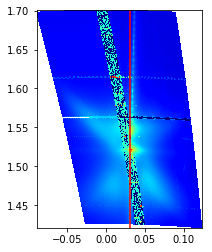

In [31]:
plt.pcolormesh(qx.transpose(0,2,1)[:,0,:],qz.transpose(0,2,1)[:,0,:],np.log(final_array.transpose(0,2,1).sum(axis=1)),cmap='jet');
plt.axis('image')
plt.plot([31e-3,31e-3],[qz.min(),qz.max()],c='r')
plt.show()

Looks like it works!

In [ ]:
plt.pcolormesh(qy[0,:,:],qz[0,:,:],np.log(final_array[400:,:,:].sum(axis=0)),cmap='jet');plt.show()

In [ ]:
plt.pcolormesh(qx[:,0,:],qz[:,0,:],np.log(final_array.sum(axis=1)),cmap='jet');
# plt.plot([31e-3,31e-3],[qz.min(),qz.max()],c='r')
plt.show()

In [ ]:
qx.transpose?